<a href="https://colab.research.google.com/github/mpratiek/END_NLP/blob/main/Evaluation_Metrics_Attn_GRU_MT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Downloading Data

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip

!unzip data.zip

--2021-12-09 13:07:52--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.79.74, 52.85.79.49, 52.85.79.23, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.79.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2021-12-09 13:07:53 (37.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.tx

In [8]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [9]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [10]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [11]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [12]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu es toute seule .', 'you re all alone .']


In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [19]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [20]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [21]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [22]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

2m 5s (- 29m 21s) (5000 6%) 2.8802
4m 5s (- 26m 37s) (10000 13%) 2.2883


KeyboardInterrupt: ignored

In [ ]:
torch.save(model, PATH)

In [23]:
evaluateRandomly(encoder1, attn_decoder1)

> je suis simplement franche .
= i m just being honest .
< i m a . . <EOS>

> vous prechez un convaincu .
= you re preaching to the choir .
< you re a liar . <EOS>

> vous etes veinarde .
= you re in luck .
< you re being . <EOS>

> c est pour vous que je suis venu .
= you re the reason i came .
< i m as i i am . <EOS>

> nous sommes tous deux celibataires .
= we re both single .
< we re both . <EOS>

> je vais avoir besoin de plus d argent .
= i m going to need some more money .
< i m going to as a . . . <EOS>

> tu es tres comprehensive .
= you re very understanding .
< you re very wise . <EOS>

> je suis epuise .
= i m exhausted .
< i m a . <EOS>

> vous etes tellement difficile !
= you re so picky .
< you re so sweet . <EOS>

> nous sommes sauvees .
= we re saved .
< we re being . <EOS>



In [24]:
def evaluateRandomly_scoring(encoder, decoder, n=10):
  actual_output = []
  predicted_output = []
  for i in range(n):
      pair = random.choice(pairs)
      print('>', pair[0])
      print('=', pair[1])
      output_words, attentions = evaluate(encoder, decoder, pair[0])
      output_sentence = ' '.join(output_words)
      print('<', output_sentence)
      print('')
      actual_output.append(pair[1])
      predicted_output.append(output_sentence.rstrip('<EOS>'))
  return actual_output,predicted_output

actual_output, predicted_output = evaluateRandomly_scoring(encoder1, attn_decoder1, n=10)

> tu es gentil .
= you re kind .
< you re being . <EOS>

> je suis promue .
= i m being promoted .
< i m a . <EOS>

> ils ne viennent pas .
= they re not coming .
< they re not tired . <EOS>

> je suis trop vieux pour vous .
= i m too old for you .
< i m too old you . <EOS>

> il se plaint toujours de quelque chose .
= he s always complaining about something .
< he is always afraid of . . . <EOS>

> il s amuse .
= he s enjoying himself .
< he is a . <EOS>

> vous etes un bon garcon .
= you are a good boy .
< you re a very . <EOS>

> je ne suis pas desespere .
= i m not desperate .
< i m not tired . <EOS>

> je me rejouis que vous soyez mon ami .
= i m glad you re my friend .
< i m glad you are my my . <EOS>

> je ne suis pas ton petit ami .
= i m not your boyfriend .
< i m not your friend . <EOS>



# Exploring different Metrics for Language Translation

# 0. Preparing the data to Calculate Metrics

In [50]:
def actual_pred_output(encoder, decoder, pairs):
  actual_output_bleu = []
  actual_output_bertscore = []
  predicted_output_bleu = []
  predicted_output_bertscore = []
  actual_blue = []

  for i in range(10):#len(pairs)):
    output_words, attention = evaluate(encoder, decoder, pairs[i][0]) #evaluate(encoder1, attn_decoder1, pairs[i][0])
    # Removing EOS at the end
    output_words.pop(-1)
    # Converting actual sentence in to a list of tokens
    actual_output_bleu.append([pairs[i][1].split()])
    predicted_output_bleu.append(output_words)
    # inputs to bertscore
    actual_output_bertscore.append(pairs[i][1])
    predicted_output_bertscore.append(' '.join(output_words))

  # actual_blue.append(actual_output_bleu)

  return actual_output_bleu, predicted_output_bleu, actual_output_bertscore, predicted_output_bertscore#, actual_blue

actual_output_bleu, predicted_output_bleu, actual_output_bertscore, predicted_output_bertscore = actual_pred_output(encoder1, attn_decoder1, pairs)

print(f'total number of samples in predicted_output : {len(predicted_output_bleu)}')
print(f'total number of samples in actual output : {len(actual_output_bleu)}')
# actual_blue
# predicted_output_bleu
### Q. Not including numbers --> Does the algorithms capable of generating realistic numbers in generated text?

total number of samples in predicted_output : 10
total number of samples in actual output : 10


In [53]:
predicted_output_bleu

[['i', 'm', 'a', '.'],
 ['i', 'm', 'going', 'to'],
 ['i', 'm', 'going', 'to', 'go', '.'],
 ['i', 'm', 'exhausted', '.'],
 ['i', 'm', 'a', '.'],
 ['i', 'm', 'in', 'a', '.'],
 ['i', 'm', 'so', '!'],
 ['i', 'm', 'so', '!'],
 ['i', 'm', 'exhausted', '.'],
 ['i', 'm', 'a', '.']]

In [42]:
actual_output_bertscore[:10], predicted_output_bertscore[:10]

(['i m .',
  'i m ok .',
  'i m ok .',
  'i m fat .',
  'i m fat .',
  'i m fit .',
  'i m hit !',
  'i m hit !',
  'i m ill .',
  'i m sad .'],
 ['i am a .',
  'i m going to',
  'i m going to go .',
  'i m exhausted .',
  'i m a .',
  'i m in a .',
  'i m so !',
  'i m so !',
  'i m exhausted .',
  'i m a .'])

In [52]:
actual_output_bleu

[[['i', 'm', '.']],
 [['i', 'm', 'ok', '.']],
 [['i', 'm', 'ok', '.']],
 [['i', 'm', 'fat', '.']],
 [['i', 'm', 'fat', '.']],
 [['i', 'm', 'fit', '.']],
 [['i', 'm', 'hit', '!']],
 [['i', 'm', 'hit', '!']],
 [['i', 'm', 'ill', '.']],
 [['i', 'm', 'sad', '.']]]

## 1. BLEU SCORE
> 1. Bilingual Evaluation Understudy   
> 2. Measures what percentage of n-grams are present both in candidate corpus and reference corpus   
> 3. BLEU1 --> counts n-grams up to a length of 1, BLEU4 --> counts n-grams up to a length of 4.   
> 4. BLEU score is not only used as a metric for Machine Translation but also for other NLG tasks. 

In [54]:
from torchtext.data.metrics import bleu_score
print(f'Bleu score when n_grams = 1, BLEU1 : {bleu_score(predicted_output_bleu,actual_output_bleu,max_n=1,weights = [1])}') # pred_output and actual_output --> should a list of lists with lists containing tokens of sentence
print(f'Bleu score when n_grams = 2, BLEU2 : {bleu_score(predicted_output_bleu,actual_output_bleu,max_n=2,weights = [0.5]*2)}')
print(f'Bleu score when n_grams = 3, BLEU3 : {bleu_score(predicted_output_bleu,actual_output_bleu,max_n=3,weights = [0.333]*3)}')
print(f'Bleu score when n_grams = 4, BLEU4 : {bleu_score(predicted_output_bleu,actual_output_bleu,max_n=4,weights = [0.25]*4)}') # default value of max_ngrams = 4

Bleu score when n_grams = 1, BLEU1 : 0.6744186282157898
Bleu score when n_grams = 2, BLEU2 : 0.45207223296165466
Bleu score when n_grams = 3, BLEU3 : 0.0
Bleu score when n_grams = 4, BLEU4 : 0.0


In [69]:
i=8
print(f'Actual/Reference sentence, Predicted sentence : {actual_output_bleu[i]}, {predicted_output_bleu[i]}')
print(f'Bleu score when n_grams = 1, BLEU1 : {bleu_score(predicted_output_bleu,actual_output_bleu)}') #,max_n=1,weights = [1])}')
# a = [['i', 'am', 'fat', '.']]
# b = [[['i', 'm', 'fat', '.']]]
# print(f'Bleu score when n_grams = 1, BLEU1 list of tokens : {bleu_score(a,b)}')

Actual/Reference sentence, Predicted sentence : [['i', 'm', 'ill', '.']], ['i', 'm', 'exhausted', '.']
Bleu score when n_grams = 1, BLEU1 : 0.0


In [30]:
candidate_corpus = [['i', 'am', 'fat', '.']]
references_corpus = [[['i', 'm', 'fat', '.']]] 
candidate_corpus1 = ['i', 'am', 'fat', '.']
references_corpus1 = ['i', 'm', 'fat', '.'] 
print(f'BLEU1_withbracket: {bleu_score(candidate_corpus, references_corpus,max_n=1,weights=[1])}')
print(f'BLEU2_withbracket: {bleu_score(candidate_corpus, references_corpus,max_n=2,weights=[0.5]*2)}')
print(f'BLEU1_nobracket: {bleu_score(candidate_corpus1, references_corpus1,max_n=1,weights=[1])}')
print(f'BLEU2_nobracket: {bleu_score(candidate_corpus1, references_corpus1,max_n=2,weights=[0.5]*2)}')

BLEU1_withbracket: 0.75
BLEU2_withbracket: 0.5
BLEU1_nobracket: 0.8571428656578064
BLEU2_nobracket: 0.0


In [31]:
candidate_corpus = [['My', 'full', 'pytorch', 'test']] #, ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test']]] #, ['Completely', 'Different']], [['No', 'Match']]]
bleu_score(candidate_corpus, references_corpus)


1.0

# PERPLEXITY 

In [32]:
import math

def evaluate_ppl(encoder, decoder, sentence, max_length=MAX_LENGTH):

    with torch.no_grad():

        input_tensor = tensorFromSentence(input_lang, sentence)

        input_length = input_tensor.size()[0]

        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)



        for ei in range(input_length):

            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)

            encoder_outputs[ei] += encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        ppl = []

        dec_out = 0

        count=0

        for di in range(max_length):

            decoder_output, decoder_hidden, decoder_attention = decoder(

                decoder_input, decoder_hidden, encoder_outputs)

            decoder_attentions[di] = decoder_attention.data

            topv, topi = decoder_output.data.topk(1)

            ppl.append(max(decoder_output.squeeze()))

            count+=1

            if topi.item() == EOS_token:

                decoded_words.append('<EOS>')

                break

            else:

                decoded_words.append(output_lang.index2word[topi.item()])

            

            decoder_input = topi.squeeze().detach()



        perplexity = math.exp(-1/count * sum(ppl))

        return perplexity, decoder_output

In [33]:
len(pairs[1][1].split(' '))

4

In [34]:
for i in range(0,1000):
  if len(pairs[i][1].split(' '))>5:
    sample_num = i
    sentence = pairs[sample_num][0]
    print(f'Input french sentence : {sentence}')
    print(f'Reference english sentence : {pairs[sample_num][1]}')
    output_words, attention = evaluate(encoder1, attn_decoder1, pairs[sample_num][0])
    output_words.pop(-1)
    print(f'Predicted english sentence : {output_words}')
    perplexity, decoder_output = evaluate_ppl(encoder1, attn_decoder1, sentence, max_length=MAX_LENGTH)
    print(f'Perplexity : {perplexity}')
    print('***************************************************************************************************')

Input french sentence : je ne suis pas flic .
Reference english sentence : i m not a cop .
Predicted english sentence : ['i', 'm', 'not', 'tired', '.']
Perplexity : 1.5809927349913935
***************************************************************************************************
Input french sentence : je ne fais pas partie de ses admirateurs .
Reference english sentence : i m not a fan .
Predicted english sentence : ['i', 'm', 'not', 'in', 'a', '.', '.']
Perplexity : 2.2440981235991035
***************************************************************************************************
Input french sentence : je ne fais pas partie de leurs admirateurs .
Reference english sentence : i m not a fan .
Predicted english sentence : ['i', 'm', 'not', 'in', '.', '.', '.']
Perplexity : 1.9426498890771497
***************************************************************************************************


In [37]:
ppl_score = {}
for i in range(1100,3100):
  if len(pairs[i][1].split(' '))>3:
    sample_num = i
    sentence = pairs[sample_num][0]
    #print(f'Input french sentence : {sentence}')
    #print(f'Reference english sentence : {pairs[sample_num][1]}')
    output_words, attention = evaluate(encoder1, attn_decoder1, pairs[sample_num][0])
    output_words.pop(-1)
    #print(f'Predicted english sentence : {output_words}')
    perplexity, decoder_output = evaluate_ppl(encoder1, attn_decoder1, sentence, max_length=MAX_LENGTH)
    #print(f'Perplexity : {perplexity}')
    #print('***************************************************************************************************')
    ppl_score[i] = perplexity
max_key = max(ppl_score, key=ppl_score.get)
print(f'Reference English sentence : {pairs[max_key][1]}')
output_words, attention = evaluate(encoder1, attn_decoder1, pairs[max_key][0])
print(f'Predicted english sentence : {output_words}')
ppl_score[max_key]

KeyboardInterrupt: ignored

In [ ]:
ppl_score

In [ ]:
actual_output, predicted_output

(['you re doing the right thing .',
  'he is bound to win the match .',
  'you re moody .',
  'i m staying .',
  'you re wrong in this case .',
  'i m engaged .',
  'he is an authority on the humanities .',
  'i m not sure i understand .',
  'i m not interested in your opinion .',
  'you aren t allowed to park there .'],
 ['you re doing the right thing . ',
  'he s going to win the . . ',
  'you re temperamental . ',
  'i m undressing . ',
  'you re out of this this . ',
  'i m engaged . ',
  'he is an authority on the . ',
  'i m not sure about understand . ',
  'i m not interested in your opinion . ',
  'you re not allowed to park there . '])

## BERT SCORE

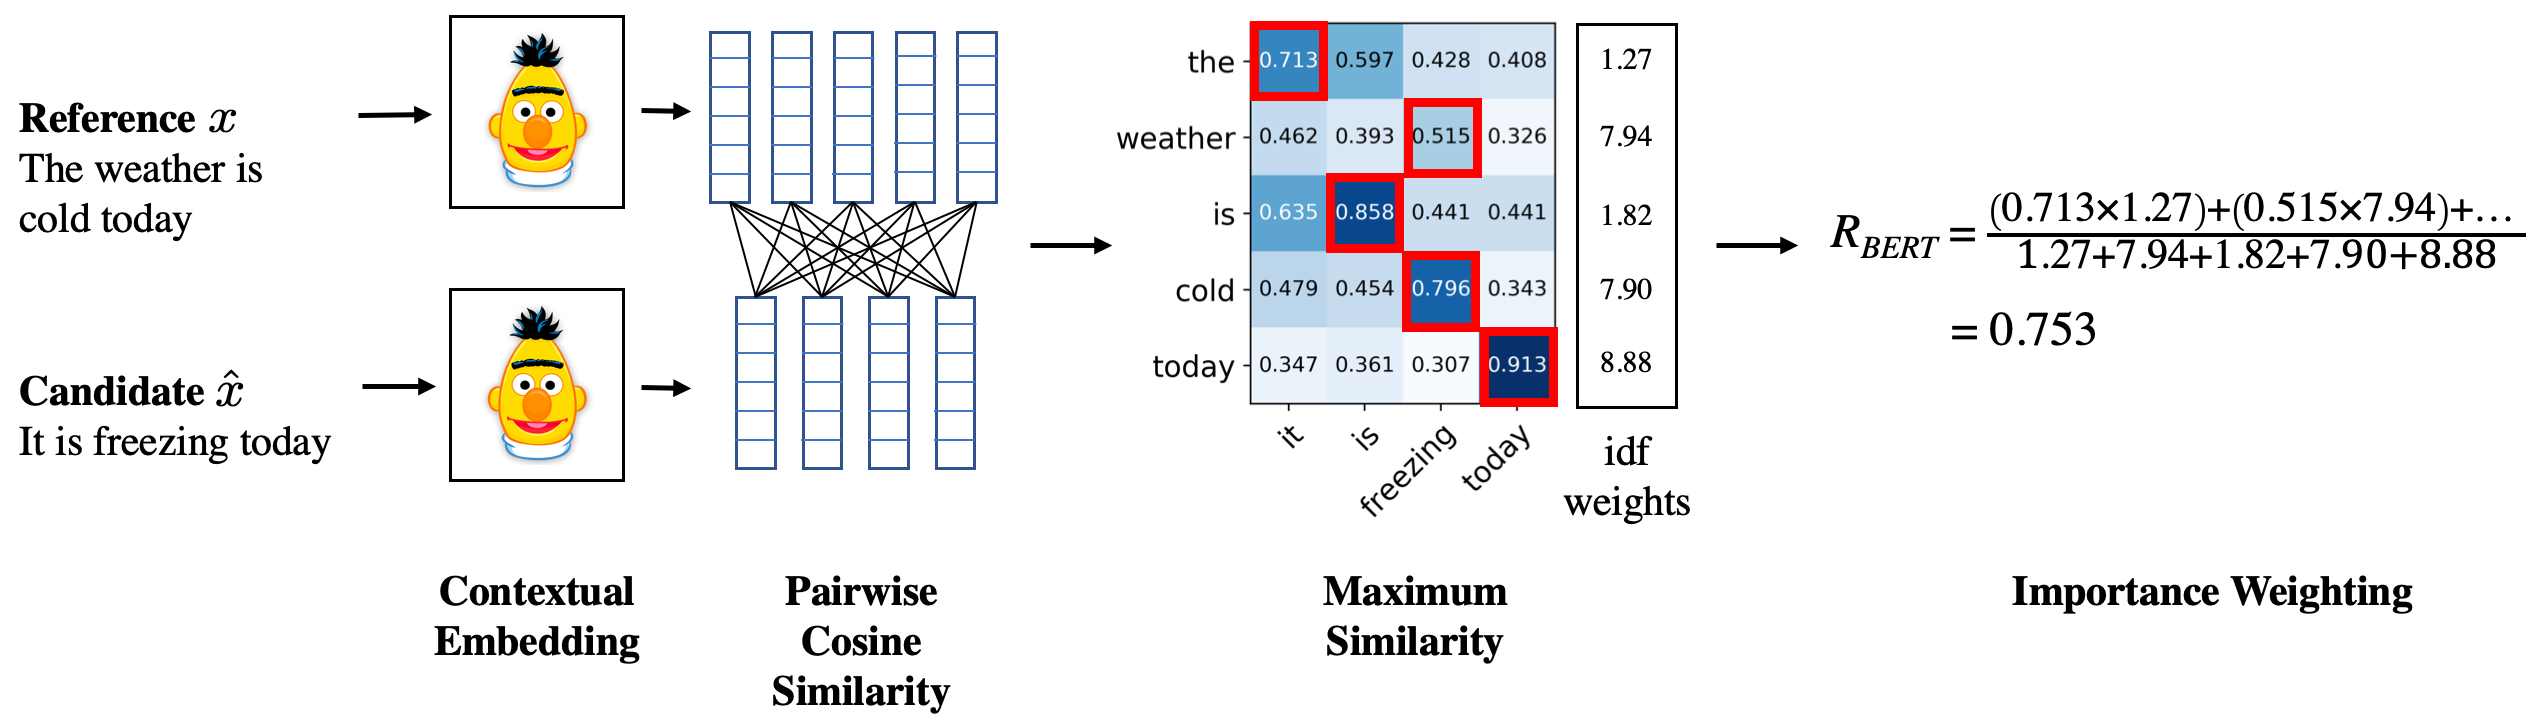

In [63]:
# Installing huggingface transformers
!pip install transformers==3.0.1

     |████████████████████████████████| 757 kB 5.2 MB/s 
     |████████████████████████████████| 3.0 MB 28.8 MB/s 
     |████████████████████████████████| 895 kB 50.3 MB/s 
     |████████████████████████████████| 1.2 MB 38.6 MB/s 


In [64]:
# Installing bertscore
!pip install bert_score==0.3.4

     |████████████████████████████████| 52 kB 907 kB/s 


In [ ]:
#https://tsdaemon.github.io/2018/07/08/nmt-with-pytorch-encoder-decoder.html



## We are now ready to call the score function. Besides candidates and references, we need to speicify the bert model we are using. Since we are dealing with English sentences, we will use the default English model, which is *roberta-large* model.

In [65]:
from bert_score import score

# When you are running this cell for the first time, 
# it will download the BERT model which will take relatively longer. 
P, R, F1 = score(predicted_output_bertscore, actual_output_bertscore, lang="en", verbose=True)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 37.88 sentences/sec


In [66]:
print(f'Precision : {P}')
print(f'Recall : {R}')
print(f'F1 score : {F1}')

print(f"System level F1 score: {F1.mean():.3f}")

Precision : tensor([0.9501, 0.8540, 0.8635, 0.9366, 0.9319, 0.9191, 0.9361, 0.9361, 0.9255,
        0.9027])
Recall : tensor([0.9809, 0.8556, 0.8859, 0.9366, 0.9331, 0.9260, 0.9438, 0.9438, 0.9178,
        0.9151])
F1 score : tensor([0.9652, 0.8548, 0.8746, 0.9366, 0.9325, 0.9225, 0.9399, 0.9399, 0.9217,
        0.9089])
System level F1 score: 0.920


In [ ]:
# # *It* might also be very interestig to see the distribution of BERTScore.

# import matplotlib.pyplot as plt
# plt.hist(F1, bins=20)
# plt.show()

## bert_score also provides a convenient function plot_example to support sentence-level visualization by plotting th e pairwise cosine similarity. 
# Note that here we have **not applied the idf weighting.**

In [ ]:
# from bert_score import plot_example

# predicted_output1 = predicted_output[0]
# actual_output1 = actual_output[0]
# plot_example(predicted_output1, actual_output1, lang="en")

In [ ]:
# actual_output[0], predicted_output[0]

In [75]:
a1 = ['i m ill .']
a2 = ['i m a student .']#['i m exhausted .']
P, R, F1 = score(a1, a2, lang="en", verbose=True)
P, R, F1

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.31 sentences/sec


(tensor([0.9227]), tensor([0.9071]), tensor([0.9148]))

In [ ]:
# actual_output, predicted_output
# actual_set = set(actual_output)
# actual_set

## Questions on the BERT Score
1. BERT models used should be coming from the similar domain otherwise the embeddings will be different?. From paper on BERTSCORE : In contrast to prior word embeddings (Mikolov et al., 2013; Pennington et al., 2014), contextual embeddings, such as BERT (Devlin et al., 2019) and ELMO (Peters et al., 2018),
can ***generate different vector representations for the same word in different sentences depending on the surrounding words, which form the context of the target word***. **Can you explain this point?**  
2. If the vocabulary of the BERT model used for scoring doesnt match well with that of the data for which embeddings are taken then the BertScore will not be correct. Is there any guideline?. May be that is the reason still the NLP community is using BLEU score


## BERT Score paper Learnings

1. **Existing metrics** for *Natural Language Generation* can be broadly categorized into using 

    1.   N-gram Matching
    2.   Edit Distance
    3. Embedding Matching or Learned functions

2. BertScore computes the similarity of 2 sentences as a SUM OF COSINE SIMILARITY between their tokens embeddings
3.   BERTSCore ***addresses 2 COMMON PIT FALLS  in N-GRAM-BASED (BLEU) metrics***:
    > **N-Gram based methods often fail to ROBUSTLY match paraphrases.**   
    Ex: Reference Sentence: "People like foreign cars"   
        Prediction1 : "People like visiting places abroad"   
        Prediction2 : "Consumers prefer imported cars"   

        **BLEU (*STRING MATCHING*)** and **METEOR (*HEURISTICS MATCHING*)** give *higher score to Prediction1* and lower *score to Prediction2*. This results in performance underestimation of semantically correct phrases.   

    > **Fail to capture *distant dependencies* and penalize semantically critical ordering changes**
For example, given a small window of size two, BLEU will only mildly penalize
swapping of cause and effect clauses (e.g. A because B instead of B because A), especially when the arguments A and B are long phrases.

4. BERTSCORE with the contextualized embeddings can take care of: a) paraphrasing and b) effectively capture distant dependencies and ordering



## Perplexity
the PPL of fixed-length models should be evaluated with a sliding-window strategy. This involves **repeatedly sliding the context window so that the model has more context when making each prediction.**

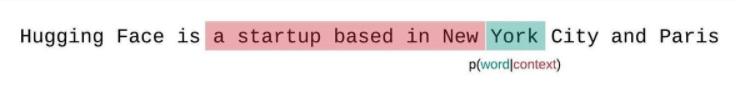

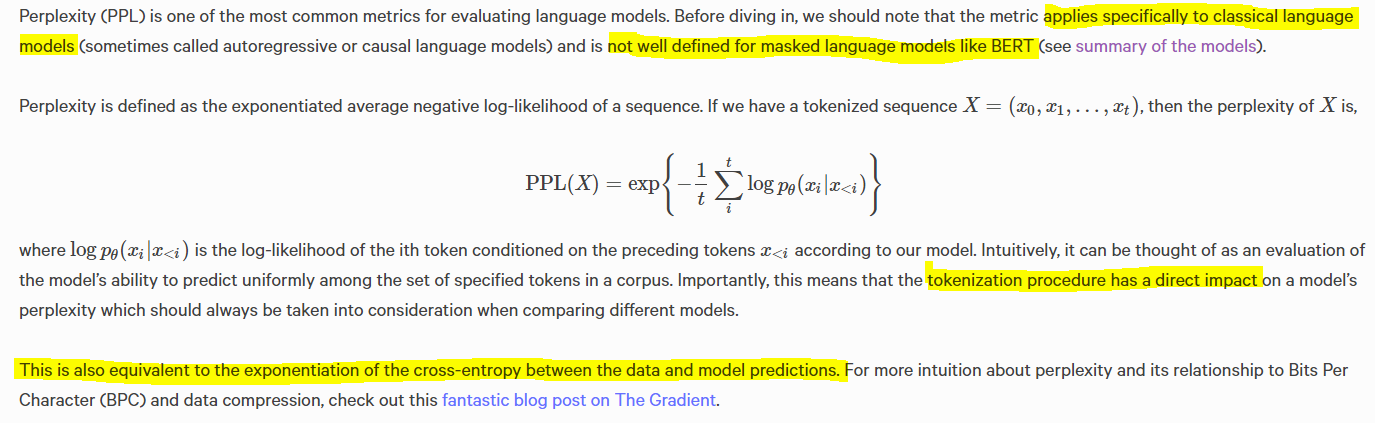

# Questions Perplexity
1. How is PERPLEXITY calculation == EXPONENTIATION of the CROSS-ENTROPY between DATA and MODEL PREDICTIONS

In [ ]:
# criterion = nn.NLLLoss()
# total_loss = 0.

# for i in range(10): #len(pairs)):
#   pred_words_index = []
#   output_words, attention = evaluate(encoder1, attn_decoder1, pairs[i][0])
#   output_words.pop(1) # removing <EOS> token
#   pred_words_index.append([for i in len(output_words)])
#   for  
#   loss = criterion(output.view(-1, ntokens), targets)
#   loss.backward()
#   total_loss += loss.item()
#   log_interval = 200
#   if batch % log_interval == 0 and batch > 0:
#       cur_loss = total_loss / log_interval
#       ...
#       print('ppl {:8.2f}'.format(math.exp(cur_loss)))

In [ ]:
# output_words